# 2D Poisson Equation

\begin{equation}
\left\{
    \begin{aligned}
        &-\Delta u =f \qquad x\in \Omega\\
        &u = 0\qquad x\in \partial \Omega
    \end{aligned}\right.
\end{equation}
where $f=10$ and the domain is chosen as a pentangle with homogeneous Dirichlet boundary condition. The difficulty of this equation is dealing with the irregular domain. To solve this problem, we triangulate the domain just like DGM or FEM. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from triangle_gauss import *
from math import pi
import numpy as np
import scipy
import time
import os
from triangle import triangulate
from scipy.interpolate import griddata
from matplotlib.path import Path
from torch.utils.tensorboard import SummaryWriter
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from utilities import *
from problems import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# ref_p, ref_w = rule(10); ref_p = ref_p.T
# plt.figure(figsize=(6, 6))
# plt.scatter(ref_p[:, 0], ref_p[:, 1], color='blue', marker='o', s=5)
# triangle_vertices = np.array([[0, 0], [1, 0], [0, 1], [0, 0]])  # 闭合三角形
# plt.plot(triangle_vertices[:, 0], triangle_vertices[:, 1], 'r-', linewidth=2)
# plt.gca().set_facecolor('#ffffff')

# plt.axis('off')
# plt.show()

## Test the mesh generation

In the whole domain: 
9 points
8 elements
16 faces/edges
Plot the mesh:


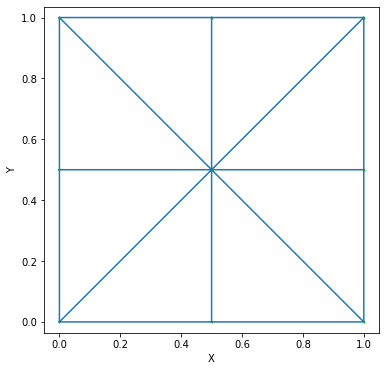

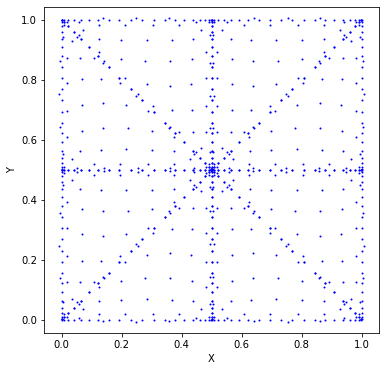

In [3]:
dg = GenMesh2D(boundary_type='regular', param='pq30a0.2e', Nint_elt=15)
dg.print_grid_info()
elt_int, elt_weights, edges_int, mesh_edge_w, mesh_normvec, Mesh, ref_Mesh, inv_matrix = dg.get_mesh()
dg.plot_mesh()
p = Mesh.reshape(-1, 2)
p = p.cpu().detach().numpy()
x = p[:, 0]
y = p[:, 1]
plt.figure(figsize=(6, 6))
plt.scatter(x, y, color='blue', marker='o', s=1)
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.show()

## DGNet

DG_2dpoisson_polygon_15_20_3_0.01_2_20_tanh
In the whole domain: 
118 points
175 elements
291 faces/edges
Plot the mesh:


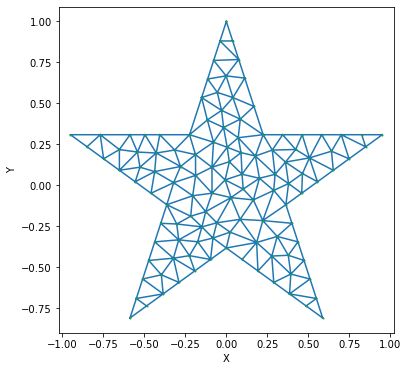

Loading saved model...
Loading saved model...
train loss:  tensor(0.0114, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor(7.4054e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>) tensor(0.0194, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)


/root/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
P_dgnet = Poisson2d_dg(boundary_type='polygon', Nint_elt=15, Nint_edge=20, order=3, partition=0.01, num_layers=2, hidden_size=20, act='tanh')
print(P_dgnet.name)
P_dgnet.genmesh.print_grid_info()
P_dgnet.genmesh.plot_mesh()
# P_dgnet.exact_loss()
retrain = False
if P_dgnet.load() and not retrain:
    print("train loss: ", P_dgnet.loss()[0], P_dgnet.loss()[1], P_dgnet.loss()[2])
elif retrain:
    P_dgnet.load()
    P_dgnet.train()


## Test hyperparameters

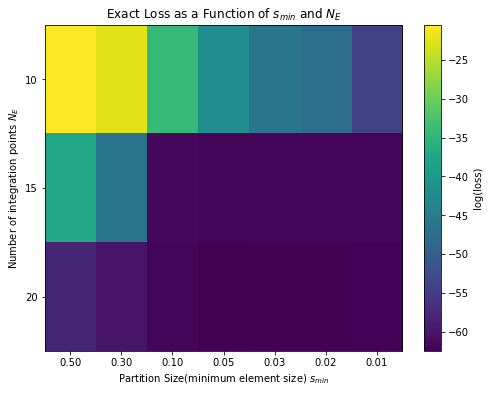

In [ ]:
N_int_elt = [10, 15, 20]
N_partitions = [0.5, 0.3, 0.1, 0.05, 0.03, 0.02, 0.01]
N_deg = [3, 6, 10, 20, 30, 60]

# 初始化存储 exact loss 的数组，行对应 N_int, 列对应 N_x
losses = np.zeros((len(N_int_elt), len(N_partitions)))

# 遍历参数组合，计算 exact loss
for i, N_int in enumerate(N_int_elt):
    for j, N_partition in enumerate(N_partitions):
        P = Poisson2d_dg(boundary_type='regular', Nint_elt=N_int, Nint_edge=20, order=3, partition=N_partition)
        losses[i, j] = P.exact_loss()

plt.figure(figsize=(8, 6))
im = plt.imshow(np.log(losses), cmap='viridis', origin='upper', aspect='auto')
plt.colorbar(im, label='log(loss)')
plt.xticks(range(len(N_partitions)), labels=[f"{p:.2f}" for p in N_partitions])
plt.yticks(range(len(N_int_elt)), labels=[f"{n}" for n in N_int_elt])
plt.xlabel(r'Partition Size(minimum element size) $s_{min}$')
plt.ylabel(r'Number of integration points $N_{E}$')
plt.title('Exact Loss as a Function of $s_{min}$ and $N_{E}$')
plt.show()

# losses = np.zeros((len(N_deg), len(N_partitions)))

# # 遍历参数组合，计算 exact loss
# for i, deg in enumerate(N_deg):
#     for j, N_partition in enumerate(N_partitions):
#         P = Poisson2d_dg(boundary_type='regular', Nint_elt=15, Nint_edge=20, order=deg, partition=N_partition)
#         losses[i, j] = P.exact_loss()
# plt.figure(figsize=(8, 6))
# im = plt.imshow(np.log(losses), cmap='viridis', origin='upper', aspect='auto')
# plt.colorbar(im, label='log(loss)')
# plt.xticks(range(len(N_partitions)), labels=[f"{p:.2f}" for p in N_partitions])
# plt.yticks(range(len(N_deg)), labels=[f"{n}" for n in N_deg])
# plt.xlabel(r'Partition Size(minimum element size) $s_{min}$')
# plt.ylabel(r'Order of test function $p$')
# plt.title('Exact Loss as a Function of $p$ and $s_{min}$')
# plt.show()

## Other baselines
Sometimes run the code below will have error, it is because the 'triangle' package is unstable. Just restart the kernel and run the first cell again. Or run the .py file.

In [2]:
P_deepritz = Poisson2d_base( method='DeepRitz', boundary_type='polygon', N_points = 100, Nint_edge=1000, num_layers=4, hidden_size=64, act='tanh')
P_deepritz.load()
# P_deepritz.train()

Loading saved model...


True

In [2]:
P_pinn = Poisson2d_base(method='PINN', boundary_type='polygon', N_points=100, Nint_edge=100, num_layers=3, hidden_size=128, act='tanh')
P_pinn.load()
# P_pinn.train()

Loading saved model...


True

## Draw pictures

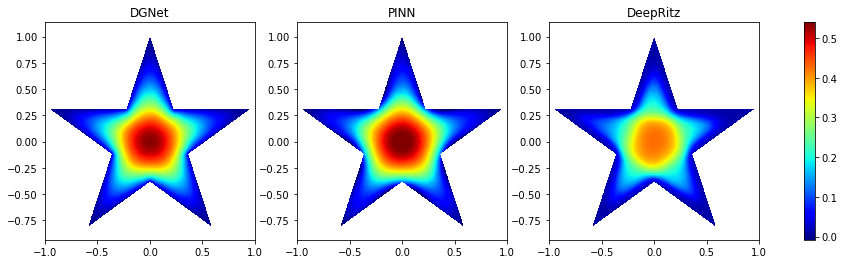

In [11]:
vtx = np.array(P_dgnet.genmesh.vertices)
path = Path(vtx)
xmin, ymin = vtx.min(axis=0)
xmax, ymax = vtx.max(axis=0)
x = np.linspace(-1, 1, 2000)
y = np.linspace(-0.9, 1.1, 2000)
X, Y = np.meshgrid(x, y)
mask = path.contains_points(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
m = np.where(mask, np.nan, 0)
cmap2 = plt.get_cmap('jet').copy()
cmap2.set_bad(alpha=0) 
cmap2.set_under('white') 

Mesh = P_dgnet.Mesh
u_deepritz = P_deepritz.model(Mesh)
u_dgnet = P_dgnet.model(Mesh)
u_pinn = P_pinn.model(Mesh)
# print(P_deepritz.loss())
u_exact = P_dgnet.u_exact
Mesh = Mesh.detach().cpu().numpy().reshape(-1, 2)
u_deepritz_pred = u_deepritz.detach().cpu().numpy().flatten()
u_dgnet_pred = u_dgnet.detach().cpu().numpy().flatten()
u_pinn_pred = u_pinn.detach().cpu().numpy().flatten()
u_exact = u_exact.detach().cpu().numpy().flatten()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
error1 = abs(u_dgnet_pred - u_exact)
error2 = abs(u_pinn_pred - u_exact)
error3 = abs(u_deepritz_pred - u_exact)




# 计算误差的范围（共享 colorbar）
# vmin = min(error1.min(), error2.min(), error3.min())
# vmax = max(error1.max(), error2.max(), error3.max())
#
# vmin = min(u_dgnet_pred.min(), u_pinn_pred.min(), u_deepritz_pred.min())
# vmax = max(u_dgnet_pred.max(), u_pinn_pred.max(), u_deepritz_pred.max())
#
vmin = u_exact.min()
vmax = u_exact.max()
#
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap("jet")

# a = axes[0].tricontourf(Mesh[:, 0], Mesh[:, 1], error1, levels=100, cmap=cmap, norm=norm)
# axes[0].pcolormesh(X, Y, m, cmap=cmap2, vmin=0.2, vmax=1)
# b = axes[1].tricontourf(Mesh[:, 0], Mesh[:, 1], error2, levels=100, cmap=cmap, norm=norm)
# axes[1].pcolormesh(X, Y, m, cmap=cmap2, vmin=0.2, vmax=1)
# c = axes[2].tricontourf(Mesh[:, 0], Mesh[:, 1], error3, levels=100, cmap=cmap, norm=norm)
# axes[2].pcolormesh(X, Y, m, cmap=cmap2, vmin=0.2, vmax=1)
#
a = axes[0].tricontourf(Mesh[:, 0], Mesh[:, 1], u_dgnet_pred, levels=100, cmap=cmap, norm=norm)
axes[0].pcolormesh(X, Y, m, cmap=cmap2, vmin=0.2, vmax=1)
b = axes[1].tricontourf(Mesh[:, 0], Mesh[:, 1], u_pinn_pred, levels=100, cmap=cmap, norm=norm)
axes[1].pcolormesh(X, Y, m, cmap=cmap2, vmin=0.2, vmax=1)
c = axes[2].tricontourf(Mesh[:, 0], Mesh[:, 1], u_deepritz_pred, levels=100, cmap=cmap, norm=norm)
axes[2].pcolormesh(X, Y, m, cmap=cmap2, vmin=0.2, vmax=1)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='vertical')
# cbar.set_label()
# axes[0].set_xlabel('x')
# axes[0].set_ylabel('y')
# axes[1].set_xlabel('x')
# axes[1].set_ylabel('y')
# axes[2].set_xlabel('x')
# axes[2].set_ylabel('y')
axes[0].axis('equal')
axes[1].axis('equal')
axes[2].axis('equal')

# 设置标题
axes[0].set_title("DGNet")
axes[1].set_title("PINN")
axes[2].set_title("DeepRitz")
# fig.tight_layout()
# fig.subplots_adjust(wspace=0.1)
plt.show()


In [6]:

# 第二层
vtx = np.array(P_dgnet.genmesh.vertices)
path = Path(vtx)
xmin, ymin = vtx.min(axis=0)
xmax, ymax = vtx.max(axis=0)
x = np.linspace(-1, 1, 2000)
y = np.linspace(-0.9, 1.1, 2000)
X, Y = np.meshgrid(x, y)
mask = path.contains_points(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
m = np.where(mask, np.nan, 0)
cmap2 = plt.get_cmap('jet').copy()
cmap2.set_bad(alpha=0) 
cmap2.set_under('white') 
# 第一层
Mesh = P_dgnet.Mesh
u = P_dgnet.model(Mesh)
u_exact = P_dgnet.u_exact
Mesh = Mesh.detach().cpu().numpy().reshape(-1, 2)
udg_pred = u.detach().cpu().numpy().flatten()
u_exact = u_exact.detach().cpu().numpy().flatten()


plt.figure(figsize=(8, 6))
# plt.tricontourf(Mesh[:, 0], Mesh[:, 1], abs(udg_pred-u_exact), levels=100, cmap='jet')
plt.tricontourf(Mesh[:, 0], Mesh[:, 1], udg_pred, levels=100, cmap='jet')
plt.colorbar()
plt.pcolormesh(X, Y, m, cmap=cmap2, vmin=0.2, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

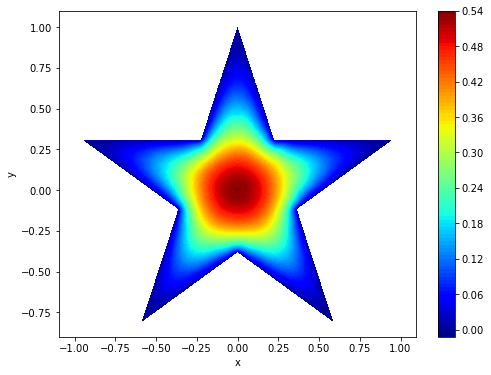